In [2]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

import numpy as np

In [3]:
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [4]:
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Tool Functions

In [9]:
from qiskit.quantum_info import DensityMatrix, Statevector, Operator

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

### - dagger and tensor 

In [14]:
state_0 = np.array([1, 0])
state_1 = np.array([0, 1])

In [12]:
from functools import reduce

Dag = lambda matrix: matrix.conj().T
Kron = lambda *matrices: reduce(np.kron, matrices)

### - pretty print

In [13]:
def pm(matrix):
    for row in range(len(matrix)):
        for col in range (len(matrix[row])):
            print("{:.3f}".format(matrix[row][col]), end = " ")
        print()

## 3. Amplitude amplification

In [1]:
# H R H, where R = 2|0><0| - I 
# A R A^(-1)

## 3.1 set up starting state

In [6]:
def initAACircuit(n):
    circuit = QuantumCircuit(n, n)
    
    circuit.x(0)
    circuit.h(1)
    circuit.z(1)
    circuit.h(0)
    circuit.barrier()
    
    return circuit

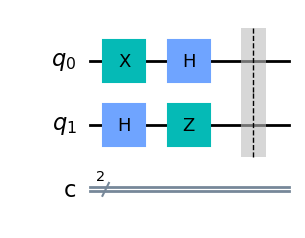

In [7]:
inputAACircuit = initAACircuit(2)
inputAACircuit.draw(output='mpl')

In [10]:
A = Operator(initAACircuit(2))

In [15]:
np.allclose(A.data @ Dag(A.data), np.eye(4))

True

### - test A

In [16]:
inputAACircuit.measure([0, 1], [0, 1])

In [17]:
job = execute(inputAACircuit, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(inputAACircuit)
print(counts)

{'01': 2483, '11': 2460, '10': 2513, '00': 2544}


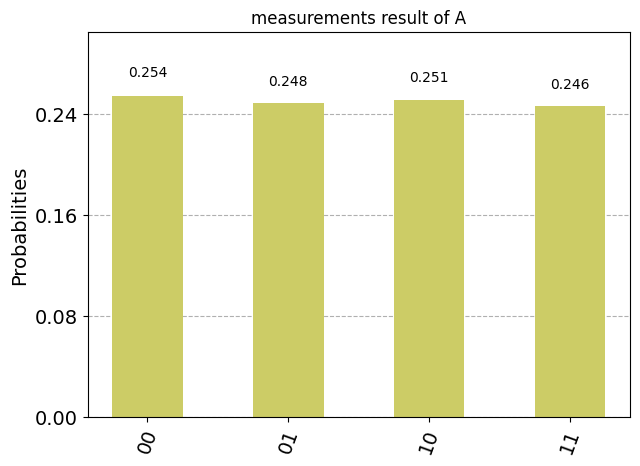

In [18]:
plot_histogram(counts, figsize=(7, 5), color="#CCCC66", title="measurements result of A")

## 3.2 Creating Oracle for finding 3

In [20]:
def createOracle_3():
    circuit = QuantumCircuit(2, 2)

    # Oracle for find 3

    # U_f 
    circuit.cz(0, 1)
    circuit.barrier()
    
    return circuit

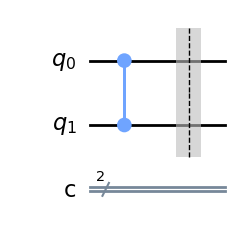

In [21]:
oracleCircuit_3 = createOracle_3()
oracleCircuit_3.draw(output='mpl')

## 3.3 Correct Diffuser

In [24]:
def createR_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.z(0)
    circuit.z(1)
    circuit.cz(0, 1)
    
    return circuit

In [31]:
def createAADiffuser():
    circuit = QuantumCircuit(2, 2)
    
    circuit.append(A, [0, 1])
    circuit = circuit.compose(createR_2q())
    circuit.append(A.conjugate(), [0, 1])
    circuit.barrier()
    
    return circuit

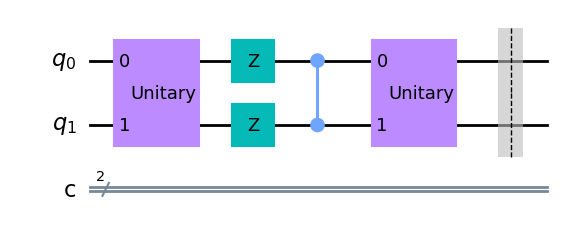

In [26]:
diffuserAACircuit = createAADiffuser()
diffuserAACircuit.draw(output='mpl')

## 3.4 Grover iteration

In [27]:
def createGroverIteration(oracle, diffuser):
    return oracle.compose(diffuser)

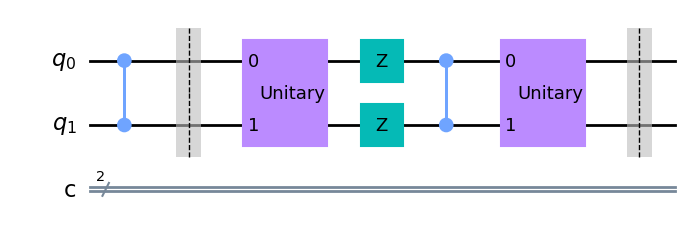

In [28]:
aaGroverIteration = createGroverIteration(createOracle_3(), createAADiffuser())
aaGroverIteration.draw(output='mpl')

## 3.5 Measure

### 3.5.1 incorrect diffuser

In [32]:
def createDiffuser_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.h(0)
    circuit.h(1)
    circuit = circuit.compose(createR_2q())
    circuit.h(0)
    circuit.h(1)
    circuit.barrier()
    
    return circuit

In [33]:
incorrectGroverIteration = createGroverIteration(createOracle_3(), createDiffuser_2q())

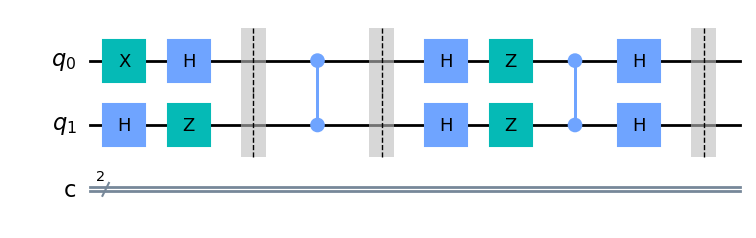

In [34]:
grover_incorrect_diffuser = initAACircuit(2).compose(incorrectGroverIteration)
grover_incorrect_diffuser.draw(output='mpl')

In [35]:
grover_incorrect_diffuser.measure([0, 1], [0, 1])

In [36]:
job = execute(grover_incorrect_diffuser, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_incorrect_diffuser)
print(counts)

{'00': 10000}


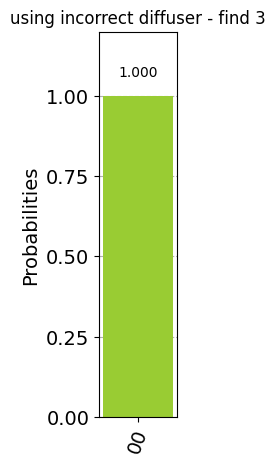

In [37]:
plot_histogram(counts, figsize=(1, 5), color="#99CC33", title="using incorrect diffuser - find 3")

In [ ]:
### 3.5.2 correct diffuser